# Data Exploration

In [43]:
from datetime import date, datetime, timedelta, time
import pandas as pd
import numpy as np
import holidays
import math
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

## Add weather data

* keep in mind that weather might not be available for future predictions depending on how far away the predicted date is from the present
* including weather data here is merely to find out if there is an impact on the number of trips

In [44]:
df = pd.read_csv("../taxi_data/taxi_data.csv", index_col=[0])
df['dt'] = df[['year', 'month', 'day', 'hour']].apply(lambda s : datetime(*s),axis = 1)
usHolidays = holidays.UnitedStates()
# add dummy for if a day is an US holiday
df["holiday"] = df["dt"].apply(lambda x: x in usHolidays).astype(int)

/Users/johannespastorek/opt/anaconda3/envs/nf/lib/python3.6/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [ ]:
w = pd.read_csv("../taxi_data/weather_prepared.csv", parse_dates=["dt"])
for i in w.columns[1:]:
    df = pd.merge(df, w[["dt", i]], on="dt", how="left")
df = df.drop("dt", axis=1)
#df.to_csv("taxi_rides_w_weather.csv")

In [50]:
df.head()

,PULocationID,year,month,day,hour,rides,dt,holiday,wday
0,2,2018,1,6,12,1,2018-01-06 12:00:00,0,5
1,2,2018,1,8,14,1,2018-01-08 14:00:00,0,0
2,2,2018,1,8,23,1,2018-01-08 23:00:00,0,0
3,2,2018,1,20,15,1,2018-01-20 15:00:00,0,5
4,4,2018,1,1,0,85,2018-01-01 00:00:00,1,0


## Add more calendar features

* adding sin and cos variation of calendar data might be helpful since there is a smoother transition between values (e.g. December (12) and January (1) are likely to behave similarly but have very different values when just using "12" and "1")

In [48]:
df["wday"] = df["dt"].apply(lambda x: x.weekday())

In [18]:
df["hour_of_week_cos"] = df["hour_of_week"].apply(lambda x: math.cos(x/168 * 2 * math.pi))
df["hour_of_week_sin"] = df["hour_of_week"].apply(lambda x: math.sin(x/168 * 2 * math.pi))
df["month_cos"] = df["month"].apply(lambda x: math.cos(x/12 * 2 * math.pi))
df["month_sin"] = df["month"].apply(lambda x: math.sin(x/12 * 2 * math.pi))
df["day_cos"] = df["day"].apply(lambda x: math.cos(x/31 * 2 * math.pi))
df["day_sin"] = df["day"].apply(lambda x: math.sin(x/31 * 2 * math.pi))
df["hour_cos"] = df["hour"].apply(lambda x: math.cos(x/24 * 2 * math.pi))
df["hour_sin"] = df["hour"].apply(lambda x: math.sin(x/24 * 2 * math.pi))
df["wday_cos"] = df["wday"].apply(lambda x: math.cos(x/7 * 2 * math.pi))
df["wday_sin"] = df["wday"].apply(lambda x: math.sin(x/7 * 2 * math.pi))

## Feature importance with XGBoost

In [36]:
cat_features = list(df1.columns[df1.dtypes==object])
cat_features

[]

In [37]:
def get_feature_importance(data, no_of_features, cats=cat_features):
    # replace cat NaNs with 'missing'
    data[cat_features] = data[cat_features].fillna('missing')
    # turn cat features into numbers
    for col in data[cat_features]:
        data[col] = pd.factorize(data[col])[0]
    # fit XGB classifier to train data
    model = XGBRegressor()
    X = data.drop(columns=['rides'])
    y = data.rides
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
    print("tts complete")
    #min_max_scaler = preprocessing.MinMaxScaler()
    #X_train = min_max_scaler.fit_transform(X_train)
    print(len(X_train))
    model.fit(X_train, y_train)
    print("fit complete")
    # zip column names with their respective feature importances
    fi = list(zip(list(X_train), model.feature_importances_))
    # sort by feature importance
    fi.sort(key=lambda x: x[1])
    # take x best features
    feature_list = list(zip(*fi[-no_of_features:]))
    # create plot
    plt.figure(figsize=(12, 5))
    plt.grid(b=None)
    plt.title('Feature Importance')
    plt.barh(range(len(feature_list[1])), feature_list[1])
    my_yticks = feature_list[0]
    plt.yticks(list(range(len(my_yticks))), my_yticks)
    plt.xlabel('Feature Score')
    plt.show()
    return my_yticks

tts complete
2401724
[11:10:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
fit complete


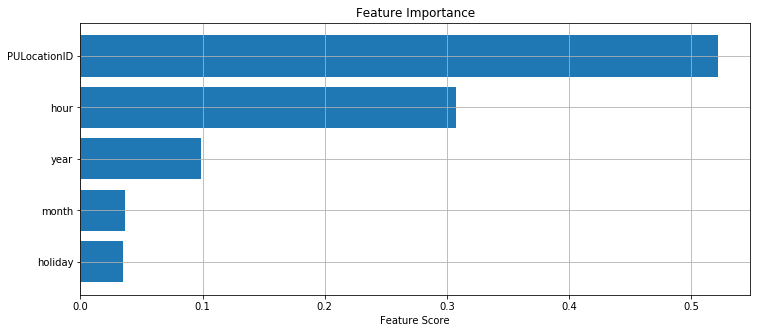

In [38]:
features = get_feature_importance(df1, len(df1.columns))

In [55]:
df1 = df[["rides", "PULocationID", "year", "month", "day", "hour", "wday", "holiday"]]

In [56]:
df1.to_csv("../taxi_data/taxi_data_final.csv")

In [57]:
df1

,rides,PULocationID,year,month,day,hour,wday,holiday
0,1,2,2018,1,6,12,5,0
1,1,2,2018,1,8,14,0,0
2,1,2,2018,1,8,23,0,0
3,1,2,2018,1,20,15,5,0
4,85,4,2018,1,1,0,0,1
5,153,4,2018,1,1,1,0,1
6,150,4,2018,1,1,2,0,1
7,97,4,2018,1,1,3,0,1
8,76,4,2018,1,1,4,0,1
9,41,4,2018,1,1,5,0,1
